# Method

A Support Vector Machine (SVM) is a supervised machine learning algorithm that can be employed for both classification and regression purposes. SVMs are more commonly used in classification problems and as such, this is what we will focus on in this post.

SVMs are based on the idea of finding a hyperplane that best divides a dataset into two classes, as shown in the image below.

<img src="https://s2.loli.net/2022/10/29/Qs9duYNAlkJLWyj.png" >

In [1]:
# import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.svm import SVC

In [2]:
# walk the downloaded dataset
for dirname, _, filenames in os.walk('../../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace('\\','/'))

../../data/clean-twitter_en.csv
../../data/clean_kaggle.csv
../../data/clean_public.csv
../../data/cyberbullying_tweets.csv
../../data/hate_speech.csv
../../data/labeled_tweets.csv
../../data/NAACL_SRW_2016.csv
../../data/public_data_labeled.csv
../../data/twitter_en.csv


In [3]:
# read the csv file
df = pd.read_csv('../../data/hate_speech.csv',index_col=0)
# only use the numerical data to predict the y variable
df = df.loc[:,['id','follower_count','friends_count','retweet_count','favorite_count','word_length','label']]
df.head(5)


,id,follower_count,friends_count,retweet_count,favorite_count,word_length,label
0,13857342,20161,780,0,0,10,0
1,13857342,20161,780,0,4,13,0
2,82522377,4,64,0,1,15,1
3,13857342,20161,780,1,30,11,0
4,930620467,18807,263,0,0,11,0


# Class distribution

Text(0, 0.5, 'Counts')

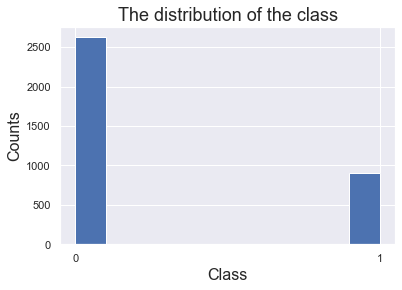

In [4]:
#plot the distribution
sns.set_theme()
plt.hist(df.label.astype('string'))
plt.title("The distribution of the class",fontsize=18)
plt.xlabel("Class",fontsize=16)
plt.ylabel("Counts",fontsize=16)

The counts of the two classes are imblanced. The labels are binary value.  In order to maintain the original imblanced distribution of the two classes, the dataset is not modified by means of upper-sampling, SMOTE, and other sampling methods to deal with imblanced issue.

# Baseline model for comparison

In [5]:
#define a baseline model which random assign labels
def random_classifier(y_data):
    ypred=[]
    max_label=np.max(y_data); #print(max_label)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))
    print("-----RANDOM CLASSIFIER-----")
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data,ypred))

random_classifier(df.label)

-----RANDOM CLASSIFIER-----
accuracy 0.5069346164732522
percision, recall, fscore, (array([0.7458287 , 0.25936599]), array([0.5106626 , 0.49614112]), array([0.6062387 , 0.34065102]), array([2626,  907], dtype=int64))


The accuracy for a random classifier is around 0.5, which makes sense to the random guess. The precision score is biased considering the imbalanced data distribution.

# Feature Engineering

In [6]:
x = df.drop('label',axis=1)
y = df.label
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
x_smote,y_smote = sm.fit_resample(x, y)

In [8]:
# normalize all the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(x_smote)
# split the data into train,test data set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smote, test_size=0.2, stratify = y_smote, random_state=42)

Overall, we select 5 numerical variable to represent the record data, and further leverage it to predict the text data.

# Model Tuning

SVM calculate distance, therefore by normalizing the data, we can train our model much faster.
Besides, hyperparemeter is significant to train a sub-optimal classification model. In this case, I leverage grid search to find out the best paremeter for my svm model.

In [9]:
#find the best hyperparametres with GridSearchCV library
parameter=[
    {"C":[1,10,100],"kernel":["linear"]},
    {"C":[1,10,100],"kernel":["rbf"],"gamma":[0.1,.3,.5,.7,.9]}
]
grid_search = GridSearchCV(SVC(), param_grid=parameter, scoring="accuracy",cv=10)
grid_search=grid_search.fit(X_train, y_train)
print("The best hyperparametres are:",grid_search.best_params_)
grid_search

The best hyperparametres are: {'C': 100, 'gamma': 0.9, 'kernel': 'rbf'}


GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': [0.1, 0.3, 0.5, 0.7, 0.9],
                          'kernel': ['rbf']}],
             scoring='accuracy')

In this part, we use “GridSearchCV” function to help us find the beset parametres so that we don’t need to write codes and make some loops manually. The result shows that **we should use rbf kernel and should set C as 100, and the gamma should be 0.9**.

# Final Result

In [10]:
#fit the model with the best hyperparametres
clf=SVC(C=100,kernel="rbf",gamma=0.9)
clf.fit(X_train,y_train)
y_pre=clf.predict(X_test)

ACCURACY: 0.6917221693625119
NEGATIVE RECALL (Y=0): 0.6539923954372624
NEGATIVE PRECISION (Y=0): 0.7078189300411523
POSITIVE RECALL (Y=1): 0.7295238095238096
POSITIVE PRECISION (Y=1): 0.6778761061946903



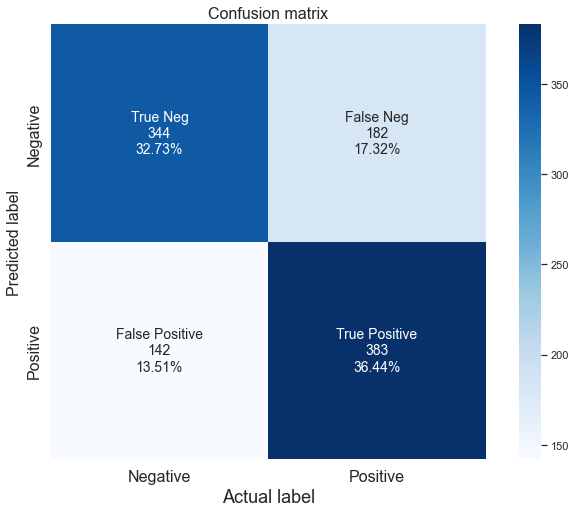

In [11]:
fig,ax = plt.subplots(figsize=(12,8))
mx = confusion_matrix(y_test,y_pre)
# cmd = ConfusionMatrixDisplay(mx,display_labels=['Positive','Negative'])
group_names = ['True Neg','False Neg','False Positive','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                mx.flatten()]
group_percentages = ["{:.2%}".format(value) for value in mx.flatten()/np.sum(mx) ]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.array(labels).reshape(2,2)
sns.heatmap(data=mx,annot=labels,fmt='',cmap='Blues',square=True,annot_kws={"fontsize":14})
ax.set_title('Confusion matrix',fontsize=16)
plt.xlabel('Actual label',fontsize=18)
plt.ylabel('Predicted label',fontsize=16)
ax.set_xticklabels(['Negative','Positive'],fontsize=16)
ax.set_yticklabels(['Negative','Positive'],fontsize=16)
plt.savefig('./confusion_matrix.png')
print(
        "ACCURACY: "+str(accuracy_score(y_test,y_pre))+"\n"+
        "NEGATIVE RECALL (Y=0): "+str(recall_score(y_test,y_pre,pos_label=0))+"\n"+
        "NEGATIVE PRECISION (Y=0): "+str(precision_score(y_test,y_pre,pos_label=0))+"\n"+
        "POSITIVE RECALL (Y=1): "+str(recall_score(y_test,y_pre,pos_label=1))+"\n"+
        "POSITIVE PRECISION (Y=1): "+str(precision_score(y_test,y_pre,pos_label=1))+"\n"
    )

It seems that we have used the best paremeter, the recall and precision rate for this classification model reaches 70% around, which is better than a random classifier.

# Conclusion

In this tab, we leverage SVM to solve the problems. The accuracy score shows that it is higher than the model we ouput with decision tree. But overall, it should still weak than the ensemble model, using random forest, or other boosting ensemble model such as XGboost.